<a href="https://colab.research.google.com/github/papchukev/demo/blob/main/%22vkr_response_bank%2Bcluster_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Аналитическая задача -- составить портрет клиента, склонного откликнуться на предложение о новой карте.

## Описание данных

|Комментарий| Признак|
|--:|:--|
|Ипотечный кредит | mortgage|
|Страхование жизни | life_ins|
|Кредитная карта | cre_card|
|Дебетовая карта | deb_card|
|Мобильный банк | mob_bank|
|Текущий счет | curr_acc|
|Интернет-доступ к счету | internet|
|Индивидуальный заем | perloan|
|Наличие сбережений | savings|
|Пользование банкоматом за последнюю неделю | atm_user|
|Пользование услугами онлайн-маркетплейса за последний месяц | markpl|
|Возраст | age |
|Давность клиентской истории | cus_leng |
|Отклик на предложение новой карты | response |

Примечание: 1 -- наличие продукта/услуги/отклика; 0 -- отсутствие продукта/услуги/отклика.

**Примерный план исследования**

Шаг 1. Загрузка данных;

Шаг 2. Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

Шаг 3. Исследовательский анализ данных
- в разрезе значений целевого признака (`response` -- Отклик на предложение новой карты	) исследовать распределения признаков;
- исследовать возможные зависимости целевого признака от объясняющих признаков;
- в разрезе целевого признака составить портреты клиентов платежной системы;

Шаг 4. Составить и проверить гипотезы о наличие/отсутствии различий по признакам портрета клиента.

Шаг 5. Построить классификационные модели.

Шаг 6. Построить модели кластеризации(сегментации) клиентов.


# Шаг 1. Загрузка данных

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [ ]:
df = pd.read_csv('/content/vrk_response_bank.csv', delimiter = ';')
df

,mortgage,life_ins,cre_card,deb_card,mob_bank,curr_acc,internet,perloan,savings,atm_user,markpl,age,cus_leng,response
0,0,0,0,0,0,0,0,0,0,0,0,18,1,0
1,1,1,0,1,1,0,0,0,0,1,0,18,2,1
2,1,1,0,1,0,0,0,0,0,0,1,18,2,1
3,1,1,1,1,0,1,0,0,0,1,1,18,2,1
4,1,1,0,1,0,0,0,1,0,1,0,18,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30254,1,1,1,1,0,1,1,0,1,1,1,63,3,0
30255,0,1,1,0,0,0,0,0,0,0,0,63,2,1
30256,1,1,1,1,0,1,0,0,1,1,1,63,3,0
30257,1,1,1,0,0,1,1,0,1,1,1,63,3,0


# Шаг 2. Первичная обработка данных

$\blacktriangleright$ Замена заголовков

In [ ]:

df.rename(columns = {'mortgage' : 'ipoteka',
                     'internet' : 'internet_dostup',
                     'perloan' : 'zaem',
                     'cus_leng' : 'history'},
          inplace = True)
df.head(5)

,ipoteka,life_ins,cre_card,deb_card,mob_bank,curr_acc,internet_dostup,zaem,savings,atm_user,markpl,age,history,response
0,0,0,0,0,0,0,0,0,0,0,0,18,1,0
1,1,1,0,1,1,0,0,0,0,1,0,18,2,1
2,1,1,0,1,0,0,0,0,0,0,1,18,2,1
3,1,1,1,1,0,1,0,0,0,1,1,18,2,1
4,1,1,0,1,0,0,0,1,0,1,0,18,2,0


$\blacktriangleright$ Проверка корректности типов данных и наличия пропущенных значений

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30259 entries, 0 to 30258
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ipoteka          30259 non-null  int64
 1   life_ins         30259 non-null  int64
 2   cre_card         30259 non-null  int64
 3   deb_card         30259 non-null  int64
 4   mob_bank         30259 non-null  int64
 5   curr_acc         30259 non-null  int64
 6   internet_dostup  30259 non-null  int64
 7   zaem             30259 non-null  int64
 8   savings          30259 non-null  int64
 9   atm_user         30259 non-null  int64
 10  markpl           30259 non-null  int64
 11  age              30259 non-null  int64
 12  history          30259 non-null  int64
 13  response         30259 non-null  int64
dtypes: int64(14)
memory usage: 3.2 MB


**Пропуски отсутствуют, типы данных корректны.**

$\blacktriangleright$ Проверка уникальных значений всех категориальных признаков

In [ ]:
for col in df.columns.drop('age'):
    print("""Уникальные значения признака "{}":{}""".format(col, df[col].unique()))

Уникальные значения признака "ipoteka":[0 1]
Уникальные значения признака "life_ins":[0 1]
Уникальные значения признака "cre_card":[0 1]
Уникальные значения признака "deb_card":[0 1]
Уникальные значения признака "mob_bank":[0 1]
Уникальные значения признака "curr_acc":[0 1]
Уникальные значения признака "internet_dostup":[0 1]
Уникальные значения признака "zaem":[0 1]
Уникальные значения признака "savings":[0 1]
Уникальные значения признака "atm_user":[0 1]
Уникальные значения признака "markpl":[0 1]
Уникальные значения признака "history":[1 2 3]
Уникальные значения признака "response":[0 1]


$\blacktriangleright$ Поиск дублирующихся записей

In [ ]:
df.duplicated().sum()

16223

В датасете **отсутствуют поля с уникальными значениями**(id клиента, дата регистрации и т.п.) и признаки принимают ограниченное количество значений(являются категориальными, кроме 'age'), поэтому **нельзя сделать однозначный вывод о наличии дубликатов**. **Удаление записей не требуется**.

In [ ]:
# словарь с переводом названий признаков
dict_perevod = {
    'ipoteka' : 'Ипотечный кредит',
    'life_ins' : 'Страхование жизни',
    'cre_card' : 'Кредитная карта',
    'deb_card' : 'Дебетовая карта',
    'mob_bank' : 'Мобильный банк',
    'curr_acc' : 'Текущий счет',
    'internet_dostup' : 'Интернет-доступ к счету',
    'zaem' : 'Индивидуальный заем',
    'savings' : 'Наличие сбережений',
    'atm_user' : 'Пользование банкоматом за последнюю неделю',
    'markpl' : 'Пользование услугами онлайн-маркетплейса за последний месяц',
    'age' : 'Возраст',
    'history' : 'Давность клиентской истории',
    'response' : 'Отклик на предложение новой карты'
    }

$\blacktriangleright$ Проверка наличия аномальных значений для признака *Возраст*:

<ipython-input-8-27b0dda29bbb>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


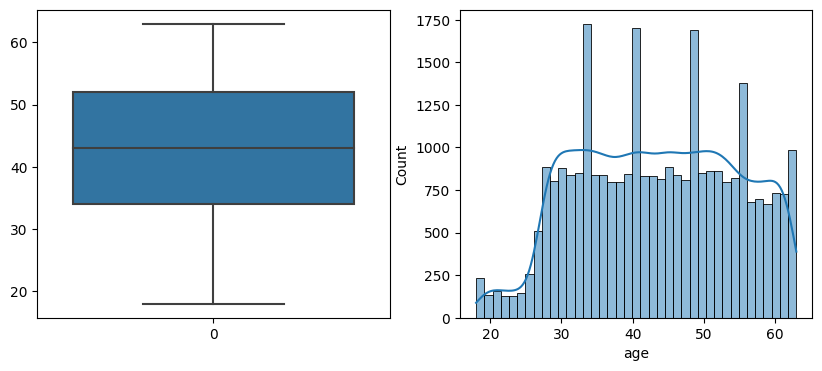

In [ ]:
fig, ax = plt.subplots(1, figsize = (10, 4))
plt.subplot(1, 2, 1)
ax = sns.boxplot(df.age)

plt.subplot(1, 2, 2)
ax = sns.histplot(df.age, kde = True)

plt.show()

In [ ]:
print("Минимальный возраст {}, максимальный возраст {}".format(df.age.min(), df.age.max()))

Минимальный возраст 18, максимальный возраст 63


У признака *Возраст*  **отсутствуют аномалии** как по значениям, так и по частоте значений.

In [ ]:
# список категориальных признаков
cat_var = list(df.columns.drop('age'))
cat_var

['ipoteka',
 'life_ins',
 'cre_card',
 'deb_card',
 'mob_bank',
 'curr_acc',
 'internet_dostup',
 'zaem',
 'savings',
 'atm_user',
 'markpl',
 'history',
 'response']

$\blacktriangleright$ Проверка аномалий по частоте значений категориальных признаков

In [ ]:
df.groupby('history')['history'].count()

history
1     5827
2    15098
3     9334
Name: history, dtype: int64

<ipython-input-12-218a02388eac>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(7, 2, i+1)
<ipython-input-12-218a02388eac>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(7, 2, i+1)
<ipython-input-12-218a02388eac>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(7, 2, i+1)
<ipython-input-12-218a02388eac>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(7, 2, i+1)
<ipython-input-12-218a02388eac>:3: MatplotlibDeprecationWarning: Auto-re

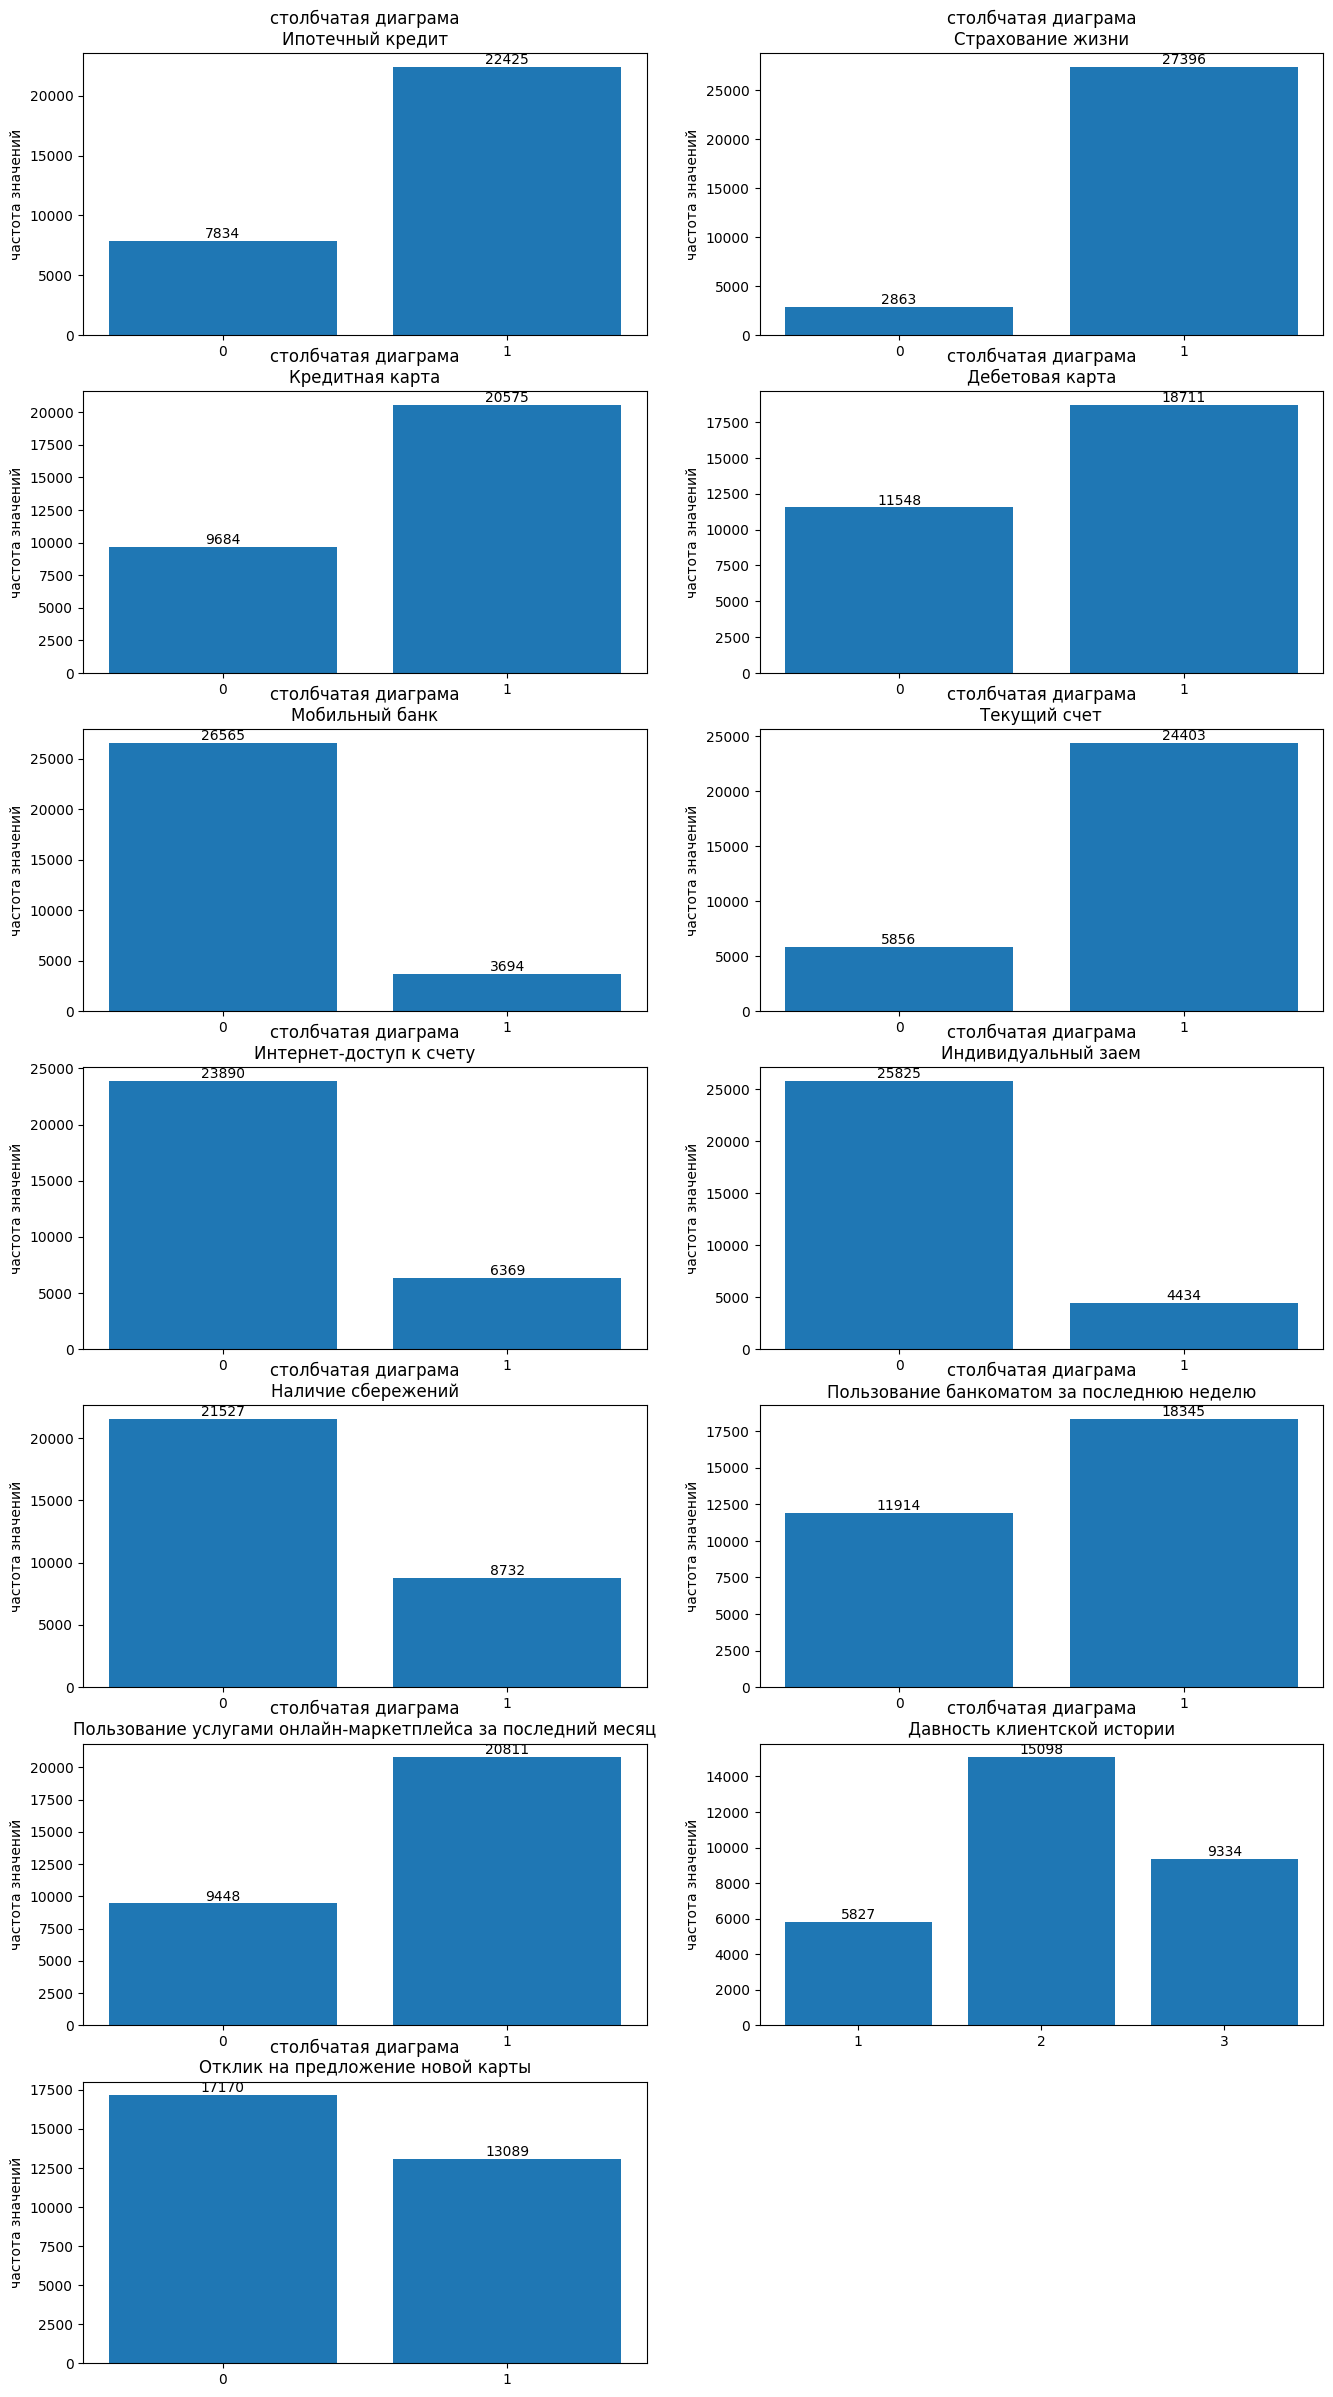

In [ ]:
fig, ax = plt.subplots(7, figsize = (16, 30))
for i, col in enumerate(cat_var):
    plt.subplot(7, 2, i+1)
    ax = plt.bar(df.groupby(col)[col].count().index,
                 df.groupby(col)[col].count())
    plt.title('столбчатая диаграма\n{}'.format(dict_perevod[col]))
    plt.xticks(ticks = df.groupby(col)[col].count().index)
    plt.ylabel('частота значений')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        plt.annotate('{:.0f}'.format(p.get_height()),
            (x.mean(), y), ha = 'center', va = 'bottom', fontsize = 10);

У категориальных признаков **отсутствуют аномалии** по частоте значений признаков (отсутствуют значения, встречающиеся очень редко).

# Шаг 3. Исследовательский анализ данных

$\blacktriangleright$ Исследуем точечные оценки и плотность распределения значений признака *'Возраст'* в разрезе целевого признака *'Отклик на предложение новой карты'*.

In [ ]:
df.groupby('response')[['age']].agg(['mean', 'median'])

age       
               mean median
response                  
0         47.760745   49.0
1         37.757354   37.0

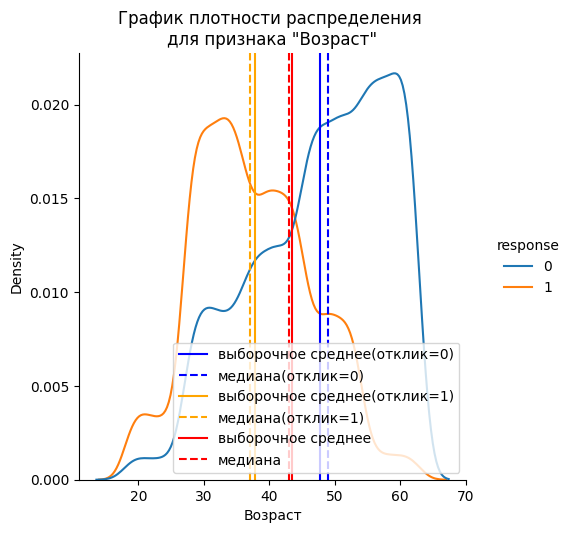

In [ ]:
sns.displot(data = df, x = df.age,  hue = 'response', kind = 'kde')
plt.axvline(df.age[df.response == 0].mean(), color = 'blue',
            label = 'выборочное среднее(отклик=0)')
plt.axvline(df.age[df.response == 0].median(), color = 'blue', ls = '--',
            label = 'медиана(отклик=0)')

plt.axvline(df.age[df.response == 1].mean(), color = 'orange',
            label = 'выборочное среднее(отклик=1)')
plt.axvline(df.age[df.response == 1].median(), color = 'orange', ls = '--',
            label = 'медиана(отклик=1)')

plt.axvline(df.age.mean(), color = 'red',
            label = 'выборочное среднее')
plt.axvline(df.age.median(), color = 'red', ls = '--',
            label = 'медиана')

plt.title('График плотности распределения \nдля признака "Возраст"')
plt.xlabel(dict_perevod['age'])
plt.legend();

По признаку ***Возраст*** в разрезе целевого признака ***Отклик на предложение новой карты*** есть различия как по точечным оценкам, так и по графикам плотности распределения:
- при наличии отклика средний возраст клиента=37.75, медиана=37,
пик графика плотности распределения расположен левее выборочного среднего и медианы по признаку *Возраст*(без учета отклика);
- при отсутствии отклика средний возраст клиента=47.76, медиана=49, пик графика плотности распределения расположен правее выборочного среднего и медианы по признаку *Возраст*(без учета отклика).

Полученные данные позволяют сделать следующие предположения:
- среднестатистический клиент, откликнувшийся на предложение о новой карте **моложе на 10 лет**, чем клиент без отклика;
- клиенты с откликом в целом **моложе**, чем клиенты без отклика;
- целевой признак "Отклик на предложение новой карты" **зависит** от признака "Возраст" .


$\blacktriangleright$ Исследуем различия по значениям категориальных признаков в разрезе целевого признака *Отклик на предложение новой карты*

In [ ]:
responce_cat_var = list(df.columns.drop(['age', 'response']))

In [ ]:
responce_cat_var

['ipoteka',
 'life_ins',
 'cre_card',
 'deb_card',
 'mob_bank',
 'curr_acc',
 'internet_dostup',
 'zaem',
 'savings',
 'atm_user',
 'markpl',
 'history']

In [ ]:
for elem in responce_cat_var:
    print("""---
Модальное значение признака '{}':
при отсутствии отклика: {}, при наличии отклика: {}""".\
          format(dict_perevod[elem], df[elem][df.response == 0].mode()[0],
                 df[elem][df.response == 1].mode()[0]))

---
Модальное значение признака 'Ипотечный кредит':
при отсутствии отклика: 1, при наличии отклика: 1
---
Модальное значение признака 'Страхование жизни':
при отсутствии отклика: 1, при наличии отклика: 1
---
Модальное значение признака 'Кредитная карта':
при отсутствии отклика: 1, при наличии отклика: 0
---
Модальное значение признака 'Дебетовая карта':
при отсутствии отклика: 1, при наличии отклика: 1
---
Модальное значение признака 'Мобильный банк':
при отсутствии отклика: 0, при наличии отклика: 0
---
Модальное значение признака 'Текущий счет':
при отсутствии отклика: 1, при наличии отклика: 1
---
Модальное значение признака 'Интернет-доступ к счету':
при отсутствии отклика: 0, при наличии отклика: 0
---
Модальное значение признака 'Индивидуальный заем':
при отсутствии отклика: 0, при наличии отклика: 0
---
Модальное значение признака 'Наличие сбережений':
при отсутствии отклика: 0, при наличии отклика: 0
---
Модальное значение признака 'Пользование банкоматом за последнюю неделю':

В разрезе целевого признака *Отклик на предложение новой карты* **есть отличия** **по модальным значениям** следующих категориальных признаков:
- *Кредитная карта* - у клиентов с откликом чаще встречается значение [0], т.е. **кредитная карта отсутствует**;
- *Пользование банкоматом за последнюю неделю* - у клиентов с откликом чаще встречается значение [0], т.е. они **не пользовались банкоматом за последнюю неделю**;
- *Пользование услугами онлайн-маркетплейса за последний месяц* - у клиентов с откликом чаще встречается значение [0], т.е. они **не пользовались услугами онлайн-маркетплейса за последний месяц**;
- *Давность клиентской истории* - у клиентов с откликом чаще встречается значение [2], а у клиентов без отклика - [3], т.е. **клиенты, которые дольше пользуются услугами банка, чаще не откликаются на предложение о новой карте.**


$\blacktriangleright$ Исследование различий в соотношениях клиентов по отдельным категориальным признакам в разрезе целевого признака *Отклик на предложение новой карты*:

<ipython-input-18-37f8f606c4ee>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,2,i)
<ipython-input-18-37f8f606c4ee>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,2,i)
<ipython-input-18-37f8f606c4ee>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,2,i)
<ipython-input-18-37f8f606c4ee>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,2,i)
<ipython-input-18-37f8f606c4ee>:4: MatplotlibDeprecationWarning: Auto-removal of overlap

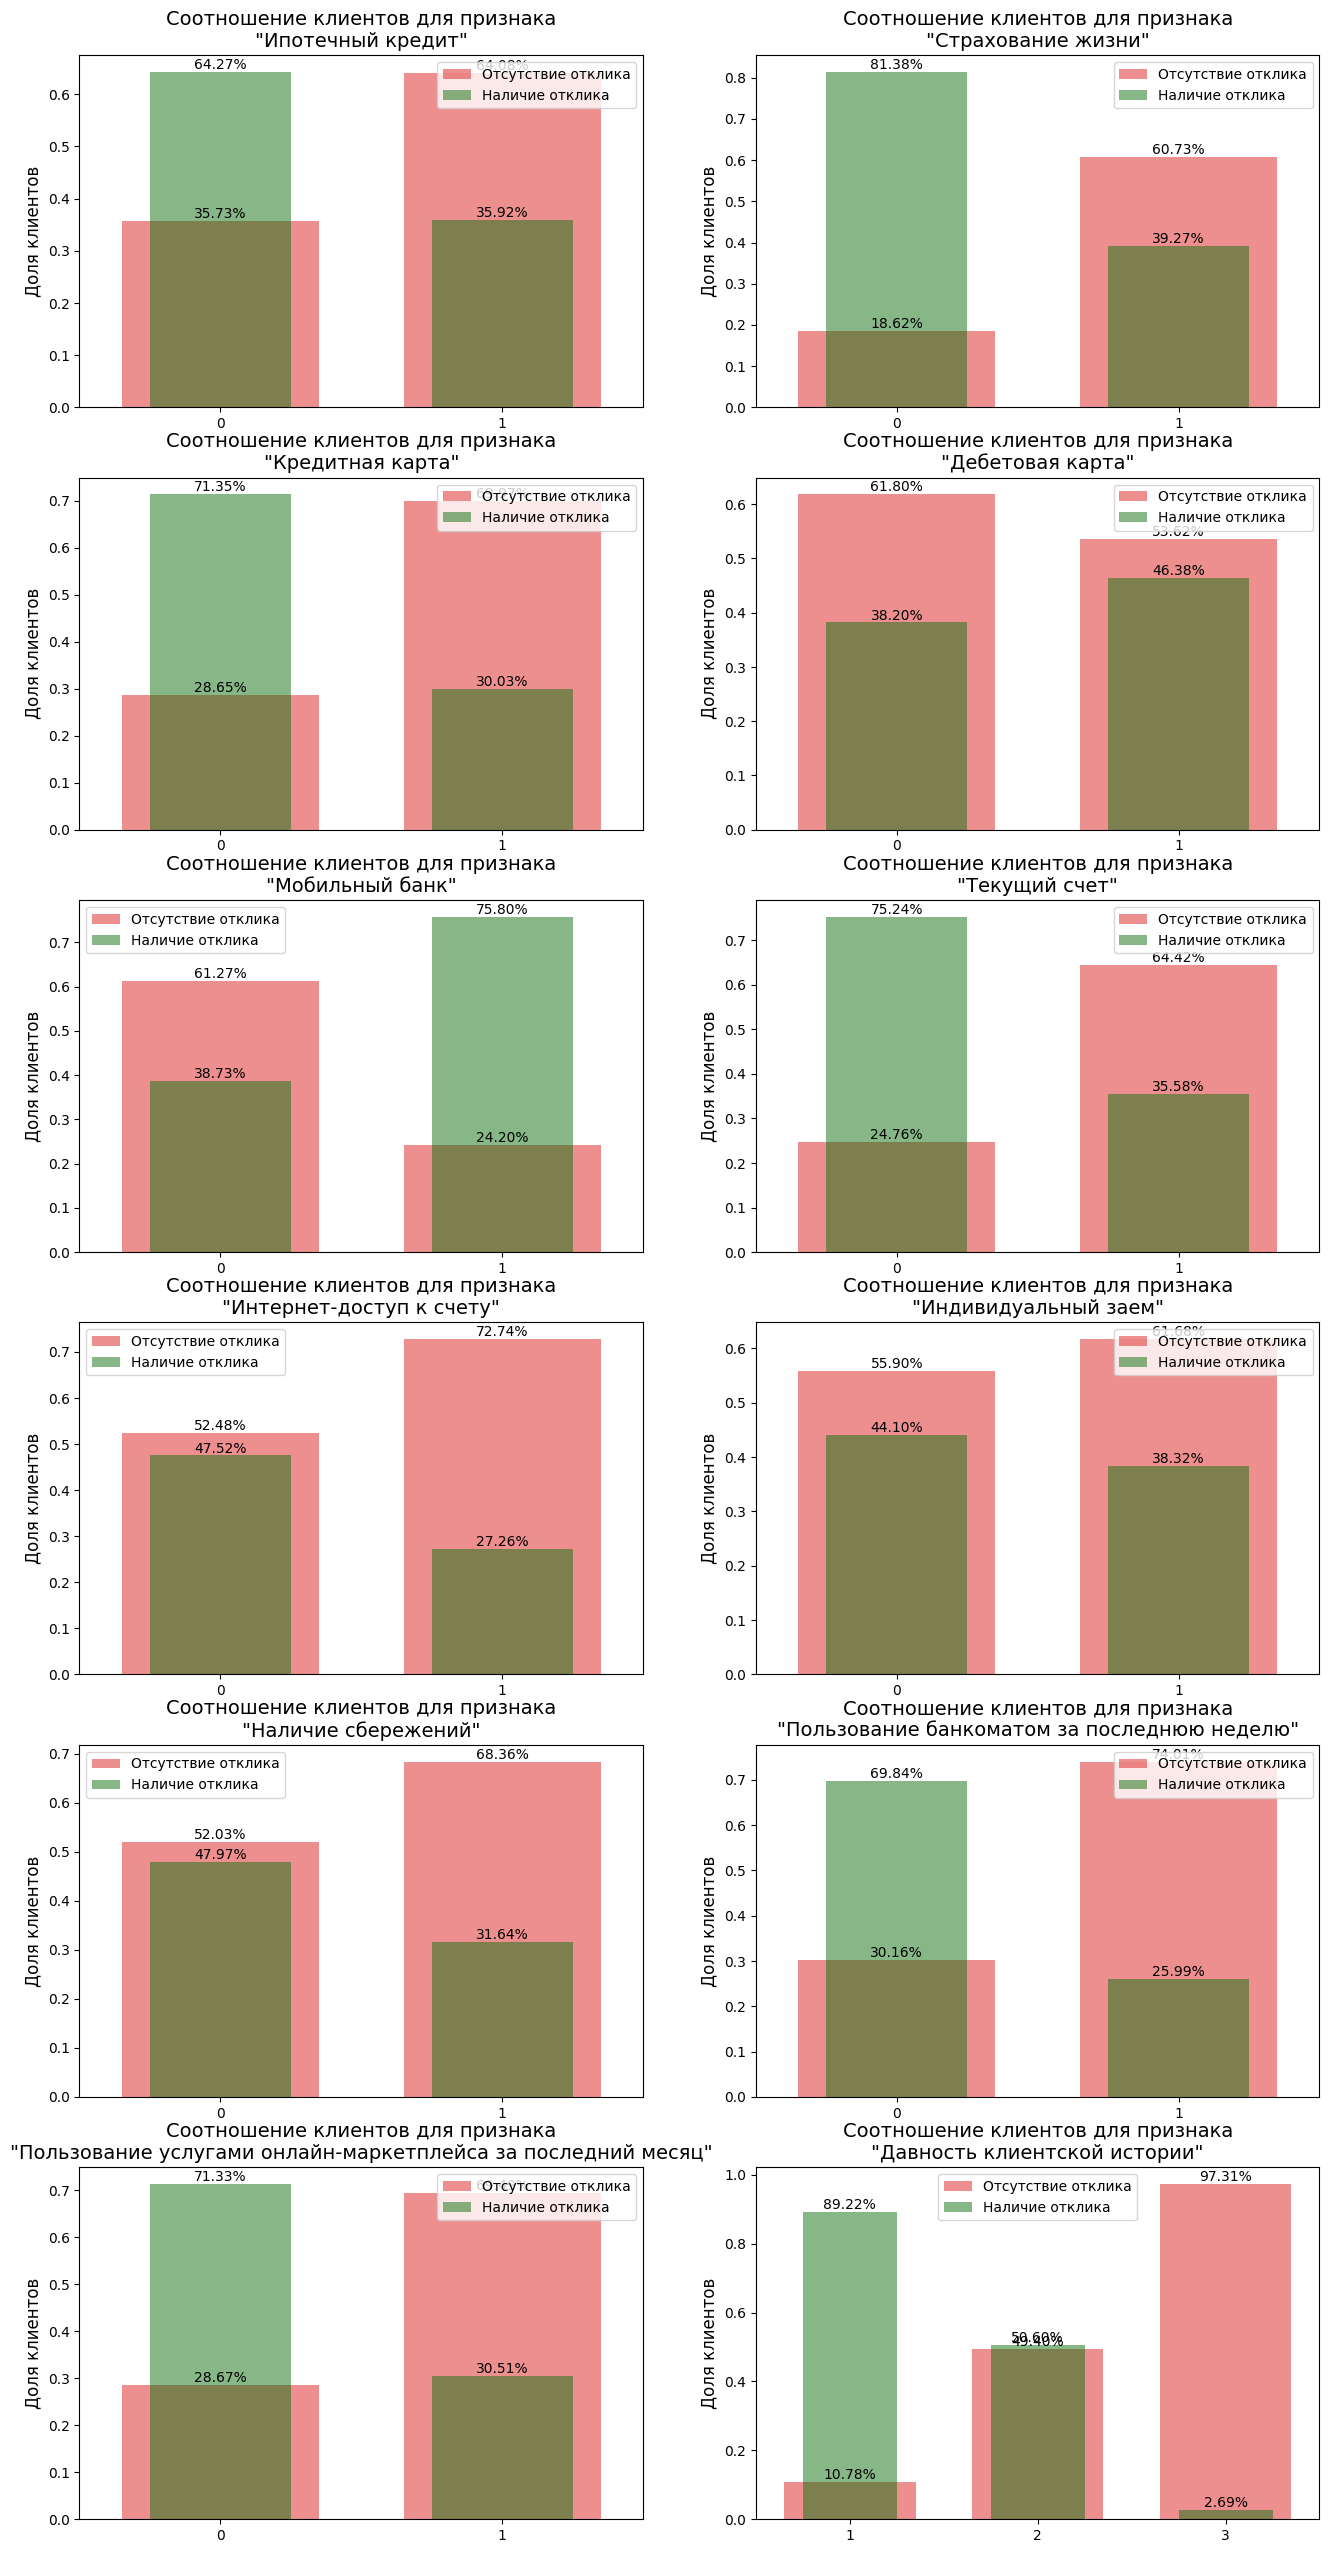

In [ ]:
#
fig, axes = plt.subplots(6, sharey = True, figsize=(16,32))
for i, col in enumerate(responce_cat_var, start = 1):
    plt.subplot(6,2,i)
    total = df[col].value_counts()
    part = (pd.DataFrame([df[df.response == 0][col].value_counts()/total,
              df[df.response == 1][col].value_counts()/total]).T)
    part.columns = ['0', '1']

    ax1 = sns.barplot(x = part.index, y = part['0'], data = part, color='red',
                      alpha = 0.5, label = 'Отсутствие отклика', width = 0.7)
    ax2 = sns.barplot(x = part.index, y = part['1'], data = part, color='green',
                      alpha = 0.5, label = 'Наличие отклика', width = 0.5)
    plt.title('Соотношение клиентов для признака\n"{}"'.format(dict_perevod[col]),
              fontsize = 14)
    plt.xlabel("")
    plt.ylabel('Доля клиентов', fontsize = 12)
    plt.legend()
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.2f}%'.format(100*y),
         (x.mean(), y),ha='center', va='bottom', fontsize = 10)

Исходя из полученных соотношений можно сделать следующие выводы:
- **значительно превосходящая доля** клиентов, откликнувшихся на предложение о новой карте среди тех, у кого:
 - есть Мобильный банк
 - нет Ипотечного кредита
 - нет Страхования жизни
 - нет Кредитной карты
 - нет Текущего счета
 - нет факта Пользования банкоматом за последнюю неделю
 - нет факта Пользования услугами интернет-маркетплейся за последний месяц
 - Давность клиентской истории равна 1 год
- доля клиентов, откликнувшихся на предложение о новой карте, **немного больше** среди тех, у кого:
 - есть Дебетовая карта
 - нет Интернет доступа к счету
 - нет Индивидуального займа
 - нет Сбережений
- по признаку Давность клиентской истории:
 - доля клиентов, откликнувшихся на предложение о новой карте **высока** среди тех, кто пользуется услугами банка **первый год**
 - примерно **равные доли** клиентов с откликом и без, среди тех, кто пользуется услугами банка **второй год**
 - **очень низкая** доля клиентов с откликом среди тех, кто пользуется услугами банка **третий год**



$\blacktriangleright$ Рассчет коэффициентов корреляции для исследования зависимости целевого признака от объясняющих признаков:

In [ ]:
df.head(2)

,ipoteka,life_ins,cre_card,deb_card,mob_bank,curr_acc,internet_dostup,zaem,savings,atm_user,markpl,age,history,response
0,0,0,0,0,0,0,0,0,0,0,0,18,1,0
1,1,1,0,1,1,0,0,0,0,1,0,18,2,1


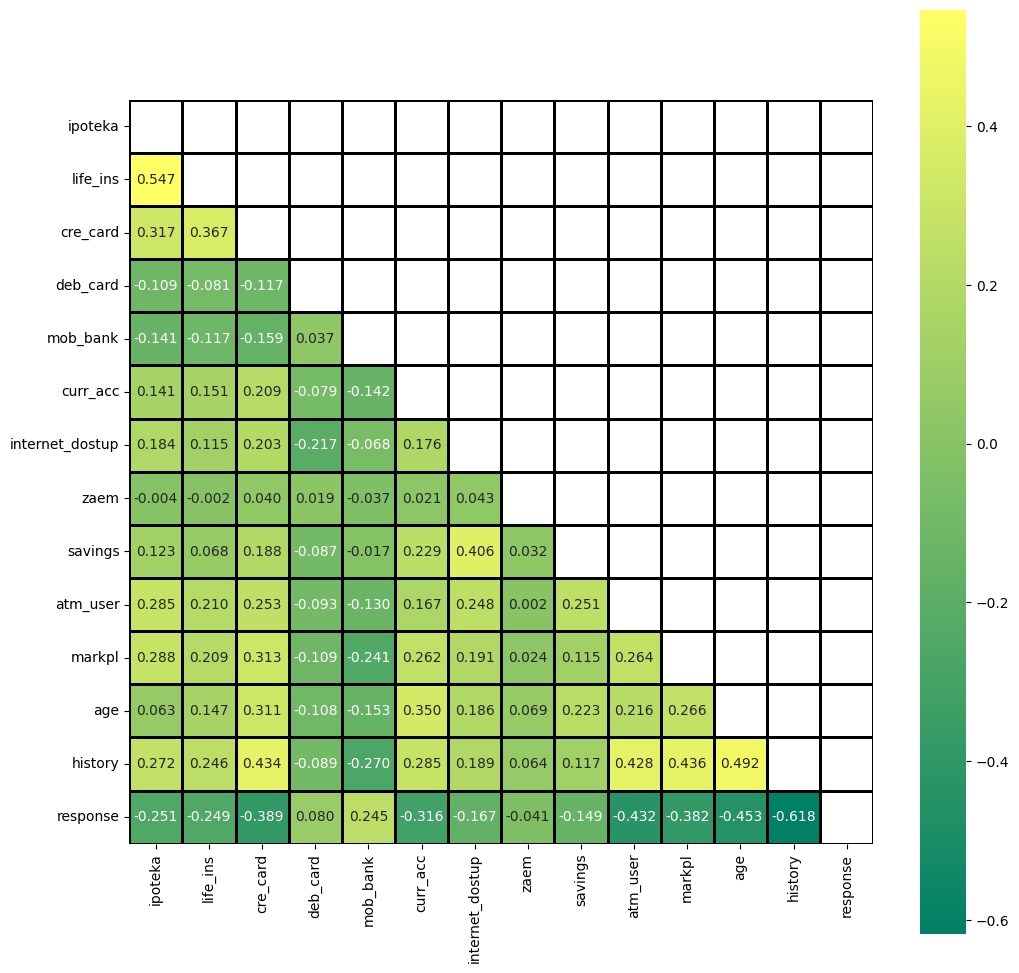

In [ ]:
# проверка на мультиколлинеарность
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data = df.corr(), annot=True, square=True,
            cmap='summer', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(df.corr()))
plt.show()

В датасете отсутствуют мультиколлинеарные признаки(значение коэффициента близкое к 1)

Для пар признаков <<*Возраст*,*Отклик на предложение новой карты*>> и <<*Давность клиентской истории*,*Отклик на предложение новой карты*>> используем "коэффициент корреляции Спирмена", "коэффициент корреляции Кендела", "бисериальный коэффициент корреляции" :

In [ ]:
print("""--------
Признаки: Возраст, Отклик на предложение новой карты
  коэффициент корреляции Спирмена {}
  коэффициент корреляции Кендела {}
  бисериальный коэффициент корреляции {}""".\
      format(stats.spearmanr(df.age, df.response),
             stats.kendalltau(df.age, df.response),
             stats.pointbiserialr(df.response, df.age)))

--------
Признаки: Возраст, Отклик на предложение новой карты
  коэффициент корреляции Спирмена SignificanceResult(statistic=-0.4553795302396509, pvalue=0.0)
  коэффициент корреляции Кендела SignificanceResult(statistic=-0.3765468495552793, pvalue=0.0)
  бисериальный коэффициент корреляции SignificanceResult(statistic=-0.4530485597310441, pvalue=0.0)


In [ ]:
print("""--------
Признаки: Давность клиентской истории, Отклик на предложение новой карты
  коэффициент корреляции Спирмена {}
  коэффициент корреляции Кендела {}
  бисериальный коэффициент корреляции {}""".\
      format(stats.spearmanr(df.history, df.response),
             stats.kendalltau(df.history, df.response),
             stats.pointbiserialr(df.response, df.history)))

--------
Признаки: Давность клиентской истории, Отклик на предложение новой карты
  коэффициент корреляции Спирмена SignificanceResult(statistic=-0.6191757570839336, pvalue=0.0)
  коэффициент корреляции Кендела SignificanceResult(statistic=-0.5887720784226478, pvalue=0.0)
  бисериальный коэффициент корреляции SignificanceResult(statistic=-0.6175826306331602, pvalue=0.0)


Остальные признаки относятся к категориальным, при этом они принимают всего два значения: 0 и 1, т.е. являются бинарными. Тип шкалы бинарных признаков можно рассматривать одновременно как номинальный, как ранговый, и как количественный. Поэтому, помимо коэффициентов кореляции, рассчитаем "коэффициент сопряженности Крамера", который характеризует тесноту связи между двумя категориальными признаками :

Для рассчета коэффициента сопряженности используется корреляционная таблица,
в которой подсчитывается число совпадений и несовпадений значений двух исследуемых признаков(в нашем случае бинарных) :

In [ ]:
pd.crosstab(df['curr_acc'], df['response'])

response,0,1
curr_acc,,
0,1450,4406
1,15720,8683


In [ ]:
stats.contingency.association(pd.crosstab(df['curr_acc'], df['response']), method = 'cramer')

0.31623343406007604

In [ ]:
binar_var = list(df.columns.drop(['age', 'history', 'response']))

In [ ]:
for elem in binar_var:
    print("""--------
Признаки: {}, Отклик на предложение новой карты
  коэффициент корреляции Спирмена {}
  коэффициент корреляции Кендела {}
  бисериальный коэффициент корреляции {}
  коэффициент сопряженности Крамера {}""".\
      format(dict_perevod[elem],
             stats.spearmanr(df[elem], df.response),
             stats.kendalltau(df[elem], df.response),
             stats.pointbiserialr(df.response, df[elem]),
             stats.contingency.association(pd.crosstab(df[elem],
                                                       df['response']),
                                           method = 'cramer')))

--------
Признаки: Ипотечный кредит, Отклик на предложение новой карты
  коэффициент корреляции Спирмена SignificanceResult(statistic=-0.2507046216714051, pvalue=0.0)
  коэффициент корреляции Кендела SignificanceResult(statistic=-0.25070462167140506, pvalue=0.0)
  бисериальный коэффициент корреляции SignificanceResult(statistic=-0.2507046216714019, pvalue=0.0)
  коэффициент сопряженности Крамера 0.2507046216714051
--------
Признаки: Страхование жизни, Отклик на предложение новой карты
  коэффициент корреляции Спирмена SignificanceResult(statistic=-0.24877773440065223, pvalue=0.0)
  коэффициент корреляции Кендела SignificanceResult(statistic=-0.2487777344006522, pvalue=0.0)
  бисериальный коэффициент корреляции SignificanceResult(statistic=-0.24877773440064893, pvalue=0.0)
  коэффициент сопряженности Крамера 0.2487777344006522
--------
Признаки: Кредитная карта, Отклик на предложение новой карты
  коэффициент корреляции Спирмена SignificanceResult(statistic=-0.38909270614501934, pvalue=

Значения коэффициентов корреляции оказались почти идентичными, поэтому для удобства сгруппируем их в один датафрейм:

In [ ]:
df_cor = pd.DataFrame(index = ['Отклик на предложение новой карты'])
df_cramer_binar = pd.DataFrame(index = ['Отклик на предложение новой карты'])

In [ ]:
for col in df.columns.drop('response'):
    df_cor[col] = stats.spearmanr(df[col], df.response)[0]
for col in binar_var:
    df_cramer_binar[col] = stats.contingency.\
    association(pd.crosstab(df[col], df['response']), method = 'cramer')

In [ ]:
df_cor = df_cor.T
df_cramer_binar = df_cramer_binar.T

In [ ]:
df_cor = (pd.concat([pd.DataFrame(list(dict_perevod.values()),
                                           index = list(dict_perevod.keys()),
                                           columns = ['расшифровка']), df_cor],
                             axis = 1,
                             sort = False,
                             join = 'inner'))
df_cramer_binar = (pd.concat([pd.DataFrame(list(dict_perevod.values()),
                                           index = list(dict_perevod.keys()),
                                           columns = ['расшифровка']),
                               df_cramer_binar],
                             axis = 1,
                             sort = False,
                             join = 'inner'))

In [ ]:
df_cor.set_index('расшифровка', inplace=True)

In [ ]:
df_cramer_binar.set_index('расшифровка', inplace=True)

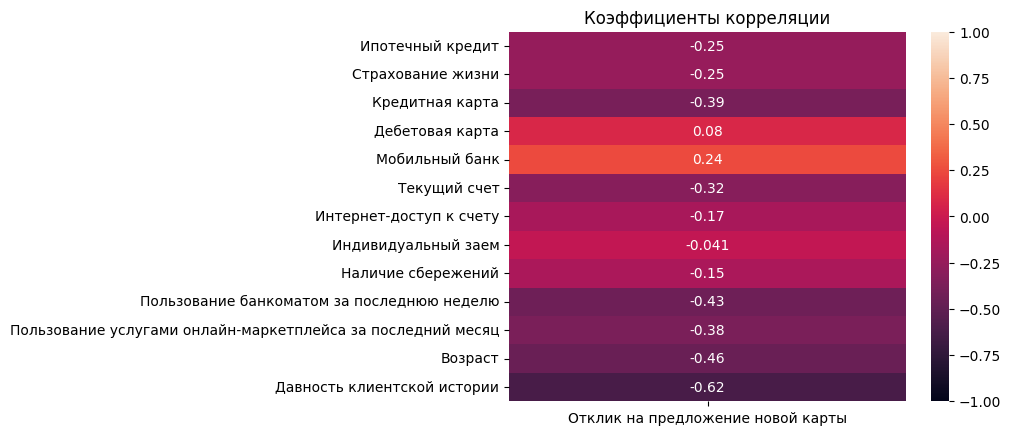

In [ ]:
sns.heatmap(df_cor, annot = True, vmin = -1, vmax = 1)
plt.ylabel('')
plt.title("Коэффициенты корреляции");

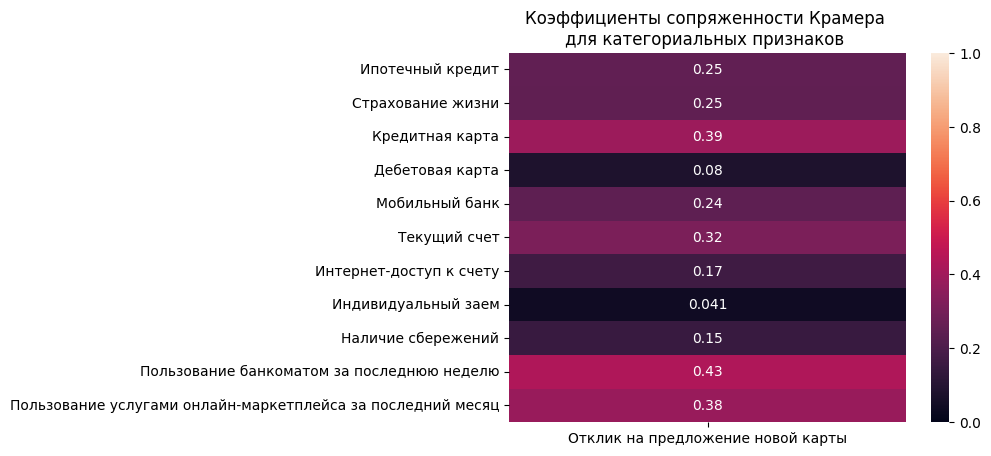

In [ ]:
sns.heatmap(df_cramer_binar, annot = True, vmin = 0, vmax = 1)
plt.ylabel('')
plt.title("Коэффициенты сопряженности Крамера \nдля категориальных признаков ");

таблица оценки тесноты связи для коэффициента сопряженности Крамера (Cramer's V)

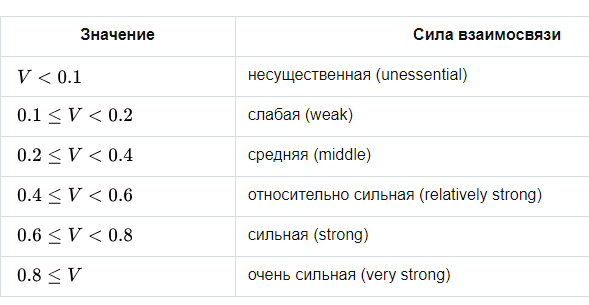

Исходя из полученных данных можно сделать следующие выводы:
- по коэффициентам корреляции:
 - у целевого признака **отсутствует** **сильная линейная зависимость**(коэф.корр.>0.75) от какого-либо из объясняющих признаков
  - **наибольшее влияние** на целевой признак оказывают признаки: *Давность клиентской истории*(-0.62) и *Возраст*(-0.46)
  - у всех признаков, за исключением *Дебетовая карта* и *Мобильный банк*, **коэффициенты корреляции имеют отрицательное значение**, т.е. увеличение объясняющего признака ведет к уменьшению целевого(отсутствие отклика)
- для бинарных признаков по коэффициентам сопряженности:
 - **относительно сильная связь** с целевым признаком у признака *Пользование банкоматом за последнюю неделю* (V=0.43)
 - **средняя связь** с целевым признаком у признаков *Кредитная карта*, *Пользование услугами интернет-маркетплейса за последний месяц*, *Текущий счет*, *Ипотечный кредит*, *Страхование жизни*, *Мобильный банк*
 - **слабая связь** с целевым признаком у признаков *Интернет доступ к счету*, *Наличие сбережений*
 - **несущественная связь** с целевым признаком у признаков *Дебетовая карта*, *Индивидуальный заем*

$\blacktriangleright$ Выводы по результатам исследовательского анализа данных следующие:
- Клиент, склонный откликнуться на предложение новой карты:
 - возраст 37 лет и моложе;
 - пользуется услугами банка 1 год;
 - не пользовался банкоматом за последнюю неделю;
 - не имеет кредитной карты;
 - не пользовался услугами интернет-маркетплейса за последний месяц;
 - не имеет текущего счета;
 - не имеет ипотечного кредита;
 - не имеет страхования жизни;
 - пользуется мобильным банком.
- Клиент, который не склонен откликнуться на предложение новой карты:
 - возраст 47 лет и старше;
 - пользуется услугами банка 3 год;
 - пользовался банкоматом за последнюю неделю;
 - имеет кредитную карту;
 - пользовался услугами интернет-маркетплейса за последний месяц;
 - имеет текущий счет;
 - имеет ипотечный кредит;
 - имеет страхование жизни;
 - не пользуется мобильным банком.


Для того, чтобы подтвердить полученные выводы, необходимо составить и проверить гипотезы о наличии разницы между признаками портрета клиента с откликом и без.

# Шаг 4. Составление и проверка статистических гипотез о разнице между признаками портрета клиента.

$\blacktriangleright$ Составление и проверка гипотез по признаку *Возраст*.

Согласно полученным точечным оценкам:
- при наличии отклика средний возраст клиента=37.75, медиана=37
- при отсутствии отклика средний возраст клиента=47.76, медиана=49.

Основная гипотеза: *возраст клиентов склонных откликнуться на предложение новой карты **меньше**, чем возраст клиентов не склонных откликнуться на предложение новой карты*.

1. Проверяем гипотезы о виде закона распределения

$H_0$:Выборки по показателям *Возраст клиентов с откликом*/*Возраст клиентов без отклика* имеют нормальное распределение

$H_1$:Выборки по показателям *Возраст клиентов с откликом*/*Возраст клиентов без отклика* имеют распределение, отличное от нормального

In [ ]:
# делим данные на 2 выборки
age_response1 = df.age[df.response == 1].copy()

age_response0 = df.age[df.response == 0].copy()

In [ ]:
print("""Проверка на нормальность с помощью критерия Колмогорова-Смирнова
Возраст клиентов с откликом {}
Возраст клиентов без отклика {}""".format(stats.kstest(age_response1, 'norm', args = (age_response1.mean(),
                                                         age_response1.std())),
             stats.kstest(age_response0, 'norm', args = (age_response0.mean(),
                                                         age_response0.std()))))

Проверка на нормальность с помощью критерия Колмогорова-Смирнова
Возраст клиентов с откликом KstestResult(statistic=0.07153735607384976, pvalue=1.0794641424461053e-58, statistic_location=35, statistic_sign=1)
Возраст клиентов без отклика KstestResult(statistic=0.08599384134043608, pvalue=6.454003658037016e-111, statistic_location=54, statistic_sign=-1)


Для двух выборок (Возраст клиентов с откликом, Возраст клиентов без отклика) с помощью критерия Колмогорова-Смирнова получено значение $p_{value} < 0.05$, следовательно гипотезу $H_0$ отвергаем и принимаем гипотезу $H_1$: **обе выборки имеют распределение, отличное от нормального**.

2. Проверяем гипотезы о равенстве параметров распределений двух выборок с помощью критерия Манна-Уитни(т.к. обе выборки имеют распределение, отличное от нормального)

$H_0$:Отсутствует статистически значимая разница между значениями *Возраст клиентов с откликом* и значениями *Возраст клиентов без отклика*

$H_1$:*Возраст клиентов с откликом* меньше, чем *Возраст клиентов без отклика*

In [ ]:
stats.mannwhitneyu(age_response1, age_response0, alternative = 'less')

MannwhitneyuResult(statistic=52757947.5, pvalue=0.0)

Для двух выборок (Возраст клиентов с откликом, Возраст клиентов без отклика) с помощью критерия Манна-Уитни получено значение $p_{value} < 0.05$, следовательно гипотезу $H_0$ отвергаем и принимаем гипотезу $H_1$: **Возраст клиентов с откликом меньше, чем Возраст клиентов без отклика**.

$\blacktriangleright$ Составление и проверка гипотез по признаку *Давность клиентской истории*.

Согласно полученным точечным оценкам:
- при наличии отклика модальное значение признака *Давность клиентской истории* = 2
- при отсутствии отклика модальное значение признака *Давность клиентской истории* = 3

Также при исследовании соотношений клиентов в разрезе целевого признака получено, что наибольшая доля клиентов с откликом среди тех, у кого *Давность клиентской истории* = 1

Основная гипотеза: *Клиенты склонные откликнуться на предложение новой карты пользуются услугами банка **меньшее количество лет**, чем клиенты не склонные откликнуться на предложение новой карты*.

1. Проверяем гипотезы о виде закона распределения

$H_0$:Выборки по показателям *Давность клиентской истории с откликом*/*Давность клиентской истории без отклика* имеют нормальное распределение

$H_1$:Выборки по показателям *Давность клиентской истории с откликом*/*Давность клиентской истории без отклика* имеют распределение, отличное от нормального

In [ ]:
# делим данные на 2 выборки
history_response1 = df.history[df.response == 1].copy()

history_response0 = df.history[df.response == 0].copy()

In [ ]:
print("""Проверка на нормальность с помощью критерия Колмогорова-Смирнова
Давность клиентской истории с откликом {}
Давность клиентской истории без отклика {}""".format(
    stats.kstest(history_response1, 'norm', args = (history_response1.mean(),
                                                    history_response1.std())),
    stats.kstest(history_response0, 'norm', args = (history_response0.mean(),
                                                    history_response0.std()))))

Проверка на нормальность с помощью критерия Колмогорова-Смирнова
Давность клиентской истории с откликом KstestResult(statistic=0.36790983209157596, pvalue=0.0, statistic_location=2, statistic_sign=-1)
Давность клиентской истории без отклика KstestResult(statistic=0.3430583495914625, pvalue=0.0, statistic_location=3, statistic_sign=-1)


Для двух выборок (Давность клиентской истории с откликом, Давность клиентской истории без отклика) с помощью критерия Колмогорова-Смирнова получено значение $p_{value} < 0.05$, следовательно гипотезу $H_0$ отвергаем и принимаем гипотезу $H_1$: **обе выборки имеют распределение, отличное от нормального**.

2. Проверяем гипотезы о равенстве параметров распределений двух выборок с помощью критерия Манна-Уитни(т.к. обе выборки имеют распределение, отличное от нормального)

$H_0$:Отсутствует статистически значимая разница между значениями *Давность клиентской истории с откликом* и значениями *Давность клиентской истории без отклика*

$H_1$:*Давность клиентской истории с откликом* меньше, чем *Давность клиентской истории без отклика*

In [ ]:
stats.mannwhitneyu(history_response1, history_response0, alternative = 'less')

MannwhitneyuResult(statistic=38089182.0, pvalue=0.0)

Для двух выборок (Давность клиентской истории с откликом, Давность клиентской истории без отклика) с помощью критерия Манна-Уитни получено значение $p_{value} < 0.05$, следовательно гипотезу $H_0$ отвергаем и принимаем гипотезу $H_1$: **"Давность клиентской истории" у клиентов с откликом меньше, чем "Давность клиентской истории" клиентов без отклика, т.е. клиенты склонные откликнуться на предложение новой карты пользуются услугами банка меньшее количество времени**.




$\blacktriangleright$ Составление и проверка гипотез для бинарных признаков.

Согласно результатам исследовательского анализа данных **доли клиентов** по каждому из категориальных признаков **в разрезе целевого признака** *Отклик на предложение новой карты* **отличаются**, т.е. значения целевого признака меняются в зависимости от значений объясняющих признаков.

Чтобы подтвердить или опровергнуть сделанные выводы, необходимо для каждого из категориальных(бинарных) признаков проверить гипотезы о равенстве долей клиентов в разрезе целевого признака.

Для каждого объясняющего бинарного признака гипотезы формулируются следующим образом:

$H_0$ : По <объясняющему признаку> **отсутствует статистически значимая разница** между долей клиентов, откликнувшихся на предложение новой карты, и долей клиентов без отклика.

$H_1$ : По <объясняющему признаку> **разница** между долей клиентов, откликнувшихся на предложение новой карты, и долей клиентов без отклика **статистически значима**.




> Для проверки гипотез о значениях параметров для биноминальных распределений используется $z-критерий$:



In [ ]:
def test_z_criterion(col, goal, alpha):
    import scipy.stats as st
    import math
    gen_group_shape = df[col].value_counts()
    goal_group_shape = df.groupby(col)[goal].sum()
    p = goal_group_shape / gen_group_shape
    p_combined = goal_group_shape.sum() / gen_group_shape.sum()
    difference = p.iloc[0] - p.iloc[1]
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/gen_group_shape.iloc[0] + 1/gen_group_shape.iloc[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Результаты проверки гипотезы H_0 по z-критерию:')
    print('Уровень значимости alpha={:.2f} P-value: {:.2f}'.format(alpha,
                                                                   p_value))

    if p_value < alpha:
        print(f"""Отвергаем нулевую гипотезу: разница в долях
по признаку <<{dict_perevod[col]}>> статистически значима.""")
    else: print(f"""Не получилось отвергнуть нулевую гипотезу: разница в долях по
признаку <<{dict_perevod[col]}>> статистически незначима.""")
    print('------------------------------------------------------------')

In [ ]:
for col in binar_var:
  test_z_criterion(col, 'response', 0.05)

Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05 P-value: 0.00
Отвергаем нулевую гипотезу: разница в долях
по признаку <<Ипотечный кредит>> статистически значима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05 P-value: 0.00
Отвергаем нулевую гипотезу: разница в долях
по признаку <<Страхование жизни>> статистически значима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05 P-value: 0.00
Отвергаем нулевую гипотезу: разница в долях
по признаку <<Кредитная карта>> статистически значима.
------------------------------------------------------------
Результаты проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha=0.05 P-value: 0.00
Отвергаем нулевую гипотезу: разница в долях
по признаку <<Дебетовая карта>> статистически значима.
--------------------------------------------------

В результате проверки гипотезы о равенстве долей с помощью $z-критерия$ получено значение $p-value < 0.05$, поэтому гипотезу $H_0$ отвергаем и принимаем гипотезу $H_1$: **разница** между долей клиентов, откликнувшихся на предложение новой карты, и долей клиентов без отклика, **статистически значима** **по каждому из категориальных(бинарных) признаков**.

# Выводы.

В результате проведенного исследовательского анализа данных были сделаны следующие предположения:
- среднестатистический клиент, откликнувшийся на предложение о новой карте **моложе на 10 лет**, чем клиент без отклика(37 и 47 лет соответственно);
- клиенты с откликом в целом **моложе**, чем клиенты без отклика;
- среди клиентов, **откликнувшихся** на предложение новой карты **высока доля** тех, у кого **отсутствуют банковские продукты/услуги** (Ипотечный кредит, Страхование жизни, Кредитная карта, Текущий счет)
- клиенты с откликом пользуются услугой Мобильный банк
- клиенты с откликом не пользовались банкоматом за последнюю неделю
- откликнувшиеся на предложение новой карты не пользовались услугами онлайн-маркетплейса за последний месяц
- на предложение новой карты **склонны откликаться** клиенты, которые **пользуются услугами банка 1 год**, при этом по мере увеличения давности клиентской истории доля откликнувшихся значительно падает
- целевой признак Отклик на предложение новой карты **не имеет очень тесной линейной связи** ни с одним из объясняющих признаков
- большее влияние на целевой признак *(по сравнению с другими)* оказывают признаки:
  - *Давность клиентской истории*(коэф.корр.=-0.62),
  - *Возраст*(коэф.корр.=-0.62),
  - *Пользование банкоматом за последнюю неделю*(коэф. сопряженности V=0.42),
  - *Кредитная карта*(V=0.39),
  - *Пользование услугами интернет-маркетплейся за последний месяц*(V=0.38)
- все признаки, кроме *Дебетовая карта* и *Мобильный банк*, имеют **отрицательный коэффициент корреляции** - увеличение значения признака ведет к уменьшению значения целевого признака.

Для проверки перечисленных предположений были составлены и проверены гипотезы:
 - для признаков Возраст и Давность клиентской истории
  - $H_0$:Отсутствует статистически значимая разница между значениями *Возраст/Давность клиентской истории* откликнувшихся на предложение новой карты и значениями *Возраст/Давность клиентской истории* клиентов без отклика.
  - $H_1$:Значения признаков *Возраст/Давность клиентской истории* откликнувшихся меньше значений *Возраст/Давность клиентской истории* клиентов без отклика.

  В результате гипотеза $H_0$ была отвергнута и **принята гипотеза $H_1$**, тем самым подтвердились предположения о том, что

  1) клиенты с откликом моложе клиентов без отклика, соответственно *Возраст* влияет на целевой признак *Отклик на предложение новой карты*;

  2) чаще откликаются клиенты которые пользуются услугами банка меньшее количество времени, соответственно *Давность клиентской истории* влияет на целевой признак *Отклик на предложение новой карты*.


- для остальных признаков,т.к. они являются категориальными и принимают всего два значения, гипотезы формулировались следующим образом
 - $H_0$ : По <объясняющему признаку> отсутствует статистически значимая разница между долей клиентов, откликнувшихся на предложение новой карты, и долей клиентов без отклика.
 - $H_1$ : По <объясняющему признаку> разница между долей клиентов, откликнувшихся на предложение новой карты, и долей клиентов без отклика статистически значима.

 В результате по каждому признаку гипотеза $H_0$ была отвергнута и **принята гипотеза $H_1$**, тем самым подтвердились предположения о том, что

  1) клиенты с откликом чаще всего **не имеют банковских продуктов/услуг**(*Ипотечный кредит, Страхование жизни, Кредитная карта, Текущий счет*);

  2) чаще откликаются клиенты, которые **пользуются услугой** *Мобильный банк*;

  3) чаще откликаются клиенты, которые **не пользовались банкоматом за последнюю неделю** и **не пользовались услугами онлайн-маркетплейса за последний месяц**;

  Помимо этого, выяснилось что, несмотря на низкие показатели корреляции и коэффициентов сопряженности по отношению к целевому признаку, **разница в долях** клиентов по признакам *Индивидуальный заем* и *Дебетовая карта* в разрезе целевого признака **оказалась статистически значимой**, т.е. исходя из полученных на этапе исследовательского анализа данных(доля откликнувшихся клиентов с Дебетовой картой-46%, без неё-38% | доля откликнувшихся клиентов с Индивидуальным займом-38%, без него-44%) можно дополнить выводы тем, что у клиентов с откликом чаще **имеется Дебетовая карта** и **отсутствует** **Индивидуальный заем**.

# Шаг 5. Построение классификационных моделей

In [ ]:
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc

In [ ]:
df.head(2)

,ipoteka,life_ins,cre_card,deb_card,mob_bank,curr_acc,internet_dostup,zaem,savings,atm_user,markpl,age,history,response
0,0,0,0,0,0,0,0,0,0,0,0,18,1,0
1,1,1,0,1,1,0,0,0,0,1,0,18,2,1


In [ ]:
# список параметров
all_var = ['ipoteka', 'life_ins',	'cre_card',	'deb_card',	'mob_bank',
           'curr_acc', 'internet_dostup',	'zaem',	'savings',	'atm_user',
           'markpl',	'age',	'history']

In [ ]:
X = df[all_var]
y = df['response']

In [ ]:
# разделение на обучающее и тестовое множество, масштабирование
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 8)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [ ]:
print("""размер обучающего множества {}
размер тестового множества {}""".format(X_train_st.shape[0], X_test_st.shape[0]))

размер обучающего множества 21181
размер тестового множества 9078


## Построение модели классификации с помощью логистической регрессии(LogisticRegression)

In [ ]:
grid_searcher = GridSearchCV(LogisticRegression(max_iter = 3000,
                                                random_state = 8,
                                                solver = 'liblinear'),
                             param_grid={'C': [0.01, 0.1, 0.5, 1, 10, 50],
                                         'penalty' : ['l1', 'l2']},
                             scoring='accuracy')

In [ ]:
grid_searcher.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=3000, random_state=8,
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 10, 50],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
grid_searcher.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [ ]:
lr = LogisticRegression(random_state = 8, max_iter = 3000, solver = 'liblinear',
                        C = 0.1, penalty = 'l1')
lr.fit(X_train_st, y_train)
y_pred = lr.predict(X_test_st)

In [ ]:
print("""accuracy = {}
precision = {}
recall_score = {}""".format(accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)))
list_lr_coef = list()
list_lr_coef.append([accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)])

accuracy = 0.8198942498347653
precision = 0.7960560456668396
recall_score = 0.7832524891498596


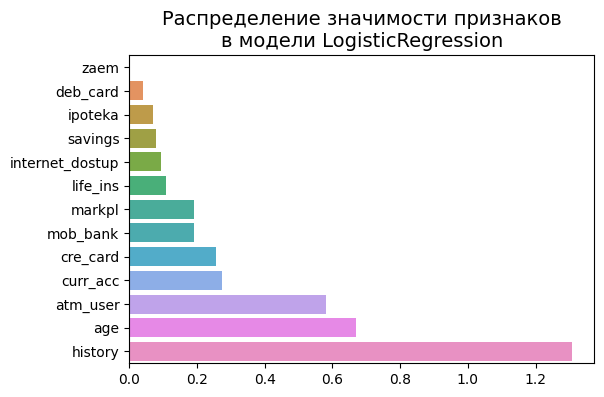

In [ ]:
logreg_coef = pd.DataFrame({'priznak' : X_train.columns,
                            'coeff' : lr.coef_.tolist()[0]})
logreg_coef['coeff'] = logreg_coef['coeff'].apply(abs)
logreg_coef.sort_values(by = 'coeff', inplace = True)
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.barplot(x='coeff', y='priznak', data = logreg_coef)
ax.set_title('Распределение значимости признаков\
\nв модели LogisticRegression',fontsize = 14)
plt.xlabel('')
plt.ylabel('');

## Построение модели классификации с помощью DecisionTreeClassifier

In [ ]:
tree_param = {'criterion':['gini','entropy'],
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid_searcher = GridSearchCV(DecisionTreeClassifier(random_state = 8), tree_param)

In [ ]:
grid_searcher.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=8),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]})

In [ ]:
grid_searcher.best_params_

{'criterion': 'entropy', 'max_depth': 7}

In [ ]:
dtc = DecisionTreeClassifier(random_state = 8,
                             criterion = 'entropy',
                             max_depth = 7)
dtc.fit(X_train_st, y_train)
y_pred = dtc.predict(X_test_st)

In [ ]:
print("""accuracy = {}
precision = {}
recall_score = {}""".format(accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)))
list_dtc_coef = list()
list_dtc_coef.append([accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)])

accuracy = 0.8165895571711831
precision = 0.7950733752620545
recall_score = 0.7745723768189942


In [ ]:
dtc.feature_importances_

array([5.29050868e-03, 4.33795229e-03, 2.26443864e-02, 2.46829600e-03,
       8.03958851e-03, 2.56307146e-02, 1.61966886e-03, 5.75550975e-04,
       1.43295407e-03, 8.18416635e-02, 1.07155928e-02, 9.31872120e-02,
       7.42215911e-01])

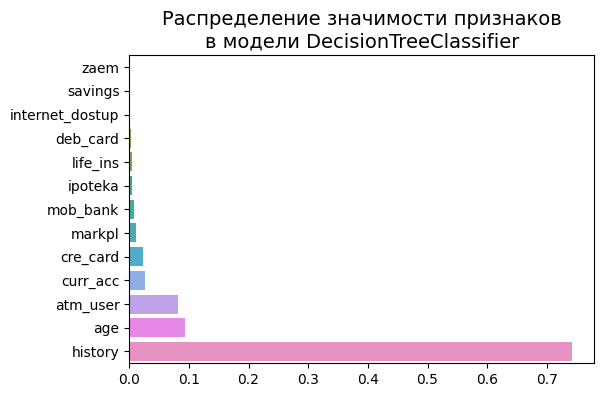

In [ ]:
dtc_coef = pd.DataFrame({'priznak' : X_train.columns,
                            'coeff' : dtc.feature_importances_.tolist()})
dtc_coef['coeff'] = dtc_coef['coeff'].apply(abs)
dtc_coef.sort_values(by = 'coeff', inplace = True)
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.barplot(x='coeff', y='priznak', data = dtc_coef)
ax.set_title('Распределение значимости признаков\
\nв модели DecisionTreeClassifier',fontsize = 14)
plt.xlabel('')
plt.ylabel('');

## Построение модели классификации с помощью RandomForestClassifier

In [ ]:
grid_searcher = GridSearchCV(RandomForestClassifier(random_state = 8),
                             param_grid={'n_estimators': [1, 20, 40, 60, 80, 100],
                                         'max_depth' :
                                          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                                         }, cv = 5, scoring='accuracy')

In [ ]:
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=8),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [1, 20, 40, 60, 80, 100]},
             scoring='accuracy')

In [ ]:
grid_searcher.best_params_

{'max_depth': 9, 'n_estimators': 100}

In [ ]:
rfc = RandomForestClassifier(random_state = 8,
                             n_estimators = 100,
                             max_depth = 9)
rfc.fit(X_train_st, y_train)
y_pred = rfc.predict(X_test_st)

In [ ]:
print("""accuracy = {}
precision = {}
recall_score = {}""".format(accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)))
list_rfc_coef = list()
list_rfc_coef.append([accuracy_score(y_test, y_pred),
                            precision_score(y_test, y_pred),
                            recall_score(y_test, y_pred)])

accuracy = 0.8226481603877506
precision = 0.7989116351386369
recall_score = 0.7870819504723002


In [ ]:
rfc.feature_importances_

array([0.01787701, 0.01225434, 0.09327911, 0.00510833, 0.0222544 ,
       0.05204897, 0.00566676, 0.00381338, 0.00632913, 0.15062359,
       0.06563882, 0.19505811, 0.37004804])

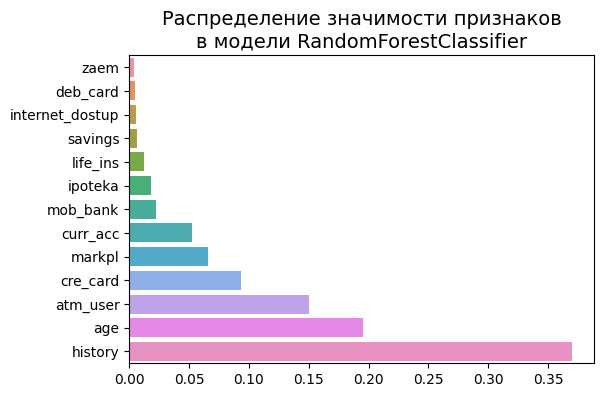

In [ ]:
rfc_coef = pd.DataFrame({'priznak' : X_train.columns,
                            'coeff' : rfc.feature_importances_.tolist()})
rfc_coef['coeff'] = rfc_coef['coeff'].apply(abs)
rfc_coef.sort_values(by = 'coeff', inplace = True)
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.barplot(x='coeff', y='priznak', data = rfc_coef)
ax.set_title('Распределение значимости признаков\
\nв модели RandomForestClassifier',fontsize = 14)
plt.xlabel('')
plt.ylabel('');

## Результаты

In [ ]:
df_model = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall'],
             columns = ['лог_регрессия', 'дерево_принятия_решений', 'случайный_лес'])
df_model['лог_регрессия'] = list_lr_coef[0]
df_model['дерево_принятия_решений'] = list_dtc_coef[0]
df_model['случайный_лес'] = list_rfc_coef[0]

df_model

,лог_регрессия,дерево_принятия_решений,случайный_лес
Accuracy,0.819894,0.816590,0.822648
Precision,0.796056,0.795073,0.798912
Recall,0.783252,0.774572,0.787082


Классификационные модели, построенные на основе всех имеющихся объясняющих признаков по установленным метрикам показали примерно **равные результаты**, при этом по метрике Accuracy лучше показала себя классификационная модель на основе RandomForestClassifier(случайный лес).

В каждой модели **наиболее значимым**  оказался признак ***Давность клиентской истории***(history), следом за ним по значимости идут признаки *Возраст*(age), *Пользование банкоматом за последнюю неделю*(atm_user), *Текущий счет*(cur_acc) и *Кредитная карта*(cre_card).

**Наименее значимым** оказался признак *Индивидуальный заем*.



# Шаг 6. Кластеризация(*сегментация*) клиентов

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans

In [ ]:
# формирование и масштабирование признакового пространства(без целевого признака)
X = df[all_var]
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

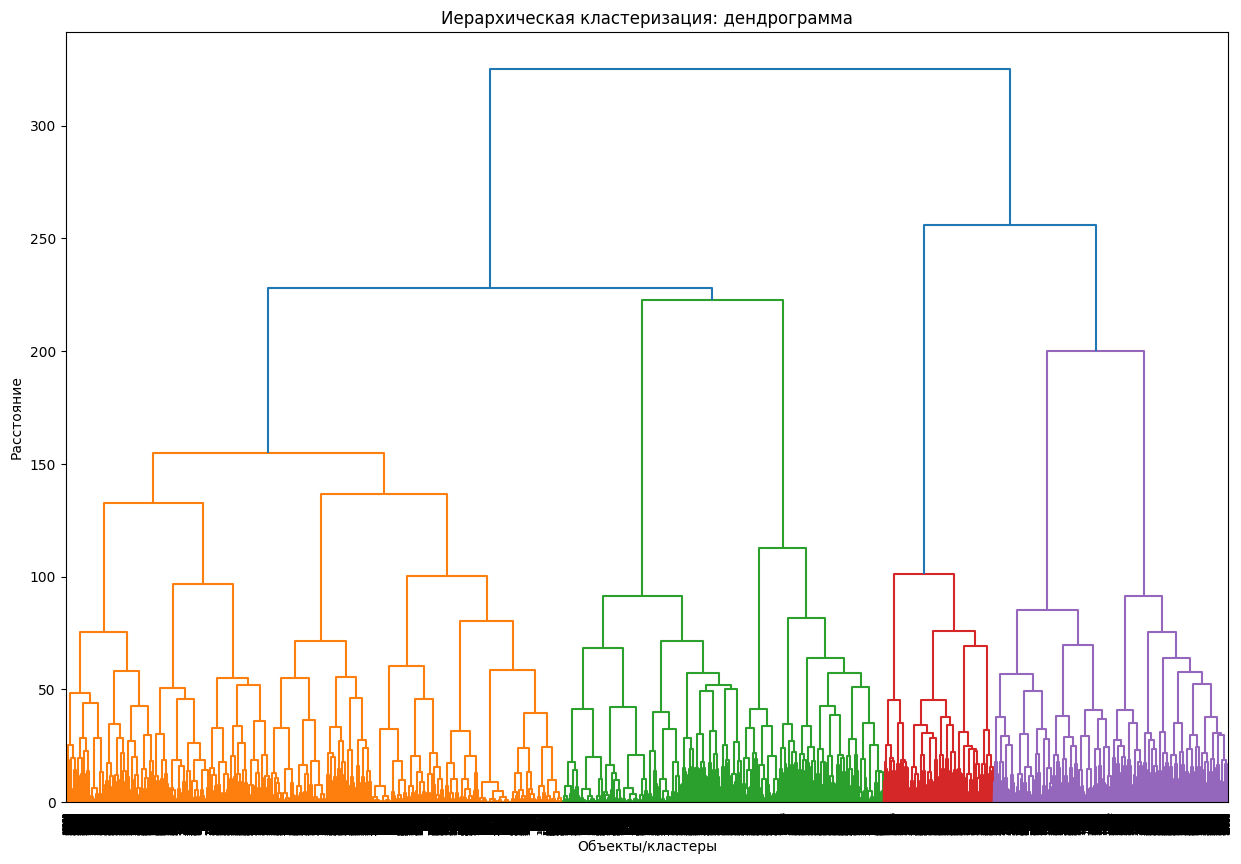

In [ ]:
# выполнение иерархической кластеризации(метод Уорда) и визуализация результата с помощью дендрограммы
plt.figure(figsize=(15, 10))
Z = linkage(X_st, method='ward')
plt.title('Иерархическая кластеризация: дендрограмма')
plt.xlabel('Объекты/кластеры')
plt.ylabel('Расстояние')
plt.xticks()
dendrogram(Z, orientation='top')
plt.show();

Визуальный анализ полученной дендрограммы позволяет предположить, что оптимальное количество кластеров равно 6, т.к. именно на последних 6 объединениях происходит значительный скачок в расстояниях между кластерами до их следующего объединения.

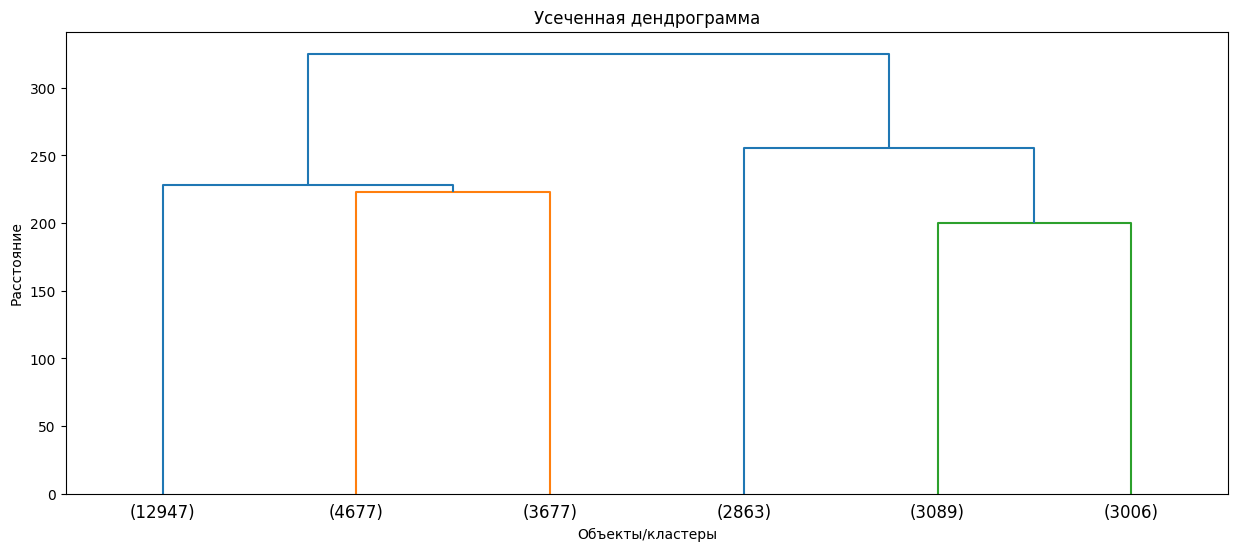

In [ ]:
plt.figure(figsize=(15, 6))
plt.title('Усеченная дендрограмма')
plt.xlabel('Объекты/кластеры')
plt.ylabel('Расстояние')
dendrogram(Z, orientation='top', truncate_mode = 'lastp', p=6)
plt.show();



$\blacktriangleright$ Обучение модели кластеризации(*алгоритм k-means*) и прогнозирование кластеров клиентов (количество кластеров = 6)

In [ ]:
km = KMeans(n_clusters = 6, random_state = 8)
notagl_cluster = km.fit_predict(X_st)

$\blacktriangleright$ Группировка и рассчет средних значений признаков по каждому кластеру, сортировка по убыванию значений признака *Отклик на предложение новой карты*

In [ ]:
df['notagl_cluster'] = notagl_cluster

In [ ]:
response_cluster_notagl = df.groupby('notagl_cluster').mean().\
sort_values(by = 'response', ascending = False)
response_cluster_notagl

,ipoteka,life_ins,cre_card,deb_card,mob_bank,curr_acc,internet_dostup,zaem,savings,atm_user,markpl,age,history,response
notagl_cluster,,,,,,,,,,,,,,
4,0.000000,0.000000,0.148705,0.741428,0.240728,0.621763,0.064031,0.149405,0.193142,0.288314,0.386634,38.436669,1.582225,0.814906
0,0.684249,1.000000,0.518370,0.670426,1.000000,0.659149,0.095671,0.098218,0.238632,0.418334,0.370316,38.457985,1.595489,0.758094
1,0.761630,1.000000,0.554753,0.688240,0.000000,0.000000,0.046807,0.126264,0.052008,0.414042,0.483097,34.305114,1.746605,0.734759
3,0.729073,1.000000,0.536155,0.695157,0.000000,1.000000,0.031068,0.136345,0.156152,0.285986,0.570343,40.300638,1.769909,0.582825
2,0.940166,0.999096,0.929320,0.407267,0.037238,0.977585,1.000000,0.188359,0.685286,0.905098,0.920282,48.827549,2.480296,0.203001
5,0.884773,1.000000,0.930502,0.602075,0.006153,0.969474,0.000000,0.151182,0.289817,0.943895,0.931588,49.805140,2.691240,0.086149


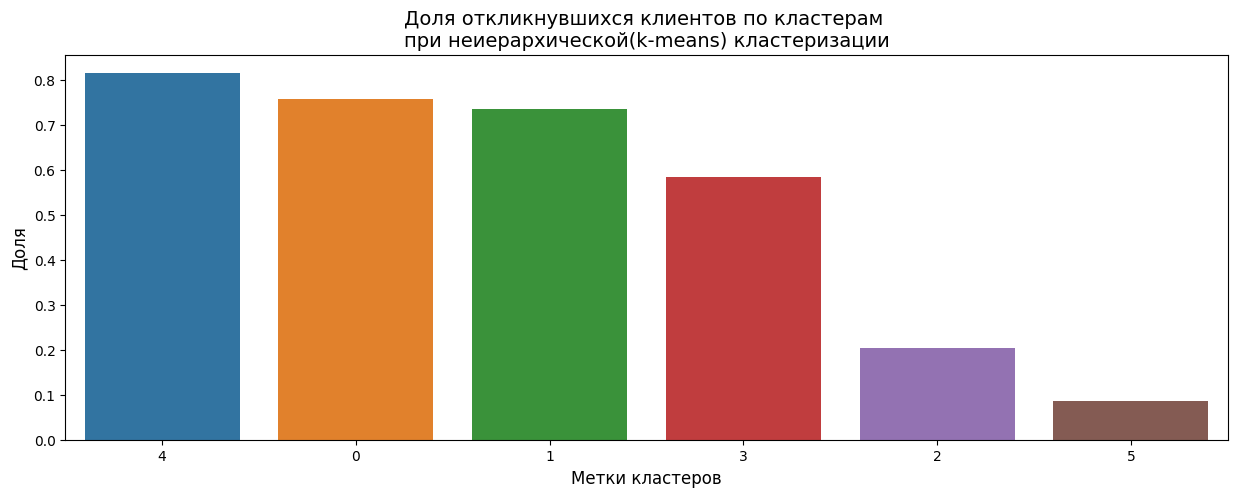

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
ax = sns.barplot(x = response_cluster_notagl.index,
                 y = 'response',
                 data = response_cluster_notagl,
                 order = response_cluster_notagl.index.to_list())
ax.set_title('Доля откликнувшихся клиентов по кластерам \nпри неиерархической(k-means) кластеризации',
             fontsize = 14)
plt.xlabel('Метки кластеров',fontsize = 12)
plt.ylabel('Доля', fontsize = 12);

Характеристика полученных кластеров:

- **Кластер "4"**:
 - **наибольшая доля** клиентов, откликнувшихся на предложение новой карты - **81%**;
 - клиенты **без** *Ипотеки* и *Страхования жизни*;
 - **большинство клиентов не пользуется** услугой *Интернет доступ к счету*;
 - наличие банковских продуктов: *Кредитная карта* есть у **14**%, *Дебетовая карта* - 74%, *Текущий счет* - 62%, *Индивидуальный займ* - 14%, *Сбережения* - 19%;
 - пользование услугами: *Мобильный банк* используют 24% клиентов, *Пользовались банкоматом за последнюю неделю* - 28%, *Пользовались услугами онлайн-маркетплейсов за последний месяц* - 38%;
 - средний *Возраст* клиентов - **38 лет** и они **пользуются услугами банка** в **среднем полтора** года;

- **Кластер "0"**:
 - доля клиентов, откликнувшихся на предложение новой карты - **75%**;
 - *Ипотека* у **68%**,  *Страхование жизни* у **всех** клиентов;
 - **большинство клиентов не пользуется** услугой *Интернет доступ к счету*;
 - наличие банковских продуктов: *Кредитная карта* есть у 51%, *Дебетовая карта* - 67%, *Текущий счет* - 65%, *Индивидуальный займ* - 9%, *Сбережения* - 23%;
 - пользование услугами: *Мобильный банк* **используют** **все** клиенты, *Пользовались банкоматом за последнюю неделю* - 41%, *Пользовались услугами онлайн-маркетплейсов за последний месяц* - 37%;
 - средний *Возраст* клиентов - **38 лет** и они **пользуются услугами банка** в **среднем полтора** года;

- **Кластер "1"**:
 - доля клиентов, откликнувшихся на предложение новой карты - **73%**;
 - *Ипотека* у **76%**,  *Страхование жизни* у **всех** клиентов;
 - **подавляющее большинство клиентов не пользуется** услугой *Интернет доступ к счету*;
 - у клиентов **нет *Текущего счета***;
 - наличие банковских продуктов: *Кредитная карта* есть у 55%, *Дебетовая карта* - 68%, *Индивидуальный займ* - 12%, *Сбережения* - 5%;
 - пользование услугами: клиенты **не пользуются** услугой *Мобильный банк*, *Пользовались банкоматом за последнюю неделю* - 41%, *Пользовались услугами онлайн-маркетплейсов за последний месяц* - 48%;
 - средний *Возраст* клиентов - **34 года** и они **пользуются услугами банка** в **среднем чуть больше полутора лет**;

- **Кластер "3"**:
 - доля клиентов, откликнувшихся на предложение новой карты - **58%**;
 - *Ипотека* у **72%**,  *Страхование жизни* у **всех** клиентов;
 - **подавляющее большинство клиентов не пользуется** услугой *Интернет доступ к счету*;
 - у всех клиентов **есть *Текущий счет***;
 - наличие банковских продуктов: *Кредитная карта* есть у 53%, *Дебетовая карта* - 69%, *Индивидуальный займ* - 13%, *Сбережения* - 15%;
 - пользование услугами: клиенты **не пользуются** услугой *Мобильный банк*, *Пользовались банкоматом за последнюю неделю* - 28%, *Пользовались услугами онлайн-маркетплейсов за последний месяц* - 57%;
 - средний *Возраст* клиентов - **40 лет** и они **пользуются услугами банка** в **среднем чуть больше полутора лет**;

- **Кластер "2"**:
 - доля клиентов, откликнувшихся на предложение новой карты - **20%**;
 - *Ипотека* у **94%**,  *Страхование жизни* у **99%** клиентов;
 - **все клиенты пользуются** услугой *Интернет доступ к счету*;
 - у **97%** клиентов есть *Текущий счет*;
 - наличие банковских продуктов: *Кредитная карта* есть у **92%**, *Дебетовая карта* - 40%, *Индивидуальный займ* - 18%, *Сбережения* - 68%;
 - пользование услугами: клиенты **очень редко пользуются** услугой *Мобильный банк*, *Пользовались банкоматом за последнюю неделю* - **90%**, *Пользовались услугами онлайн-маркетплейсов за последний месяц* - **92%**;
 - средний *Возраст* клиентов - **48 лет** и они **пользуются услугами банка** в **среднем два с половиной года**;

- **Кластер "5"**:
 - **наименьшая доля** клиентов, откликнувшихся на предложение новой карты - **8%**;
 - *Ипотека* у **88%**,  *Страхование жизни* у **всех** клиентов;
 - **не пользуются** услугой *Интернет доступ к счету*;
 - у **96%** клиентов есть *Текущий счет*;
 - наличие банковских продуктов: *Кредитная карта* есть у **93%**, *Дебетовая карта* - 60%, *Индивидуальный займ* - 15%, *Сбережения* - 28%;
 - пользование услугами: клиенты **почти не пользуются(0.6%)** услугой *Мобильный банк*, *Пользовались банкоматом за последнюю неделю* - **94%**, *Пользовались услугами онлайн-маркетплейсов за последний месяц* - **93%**;
 - средний *Возраст* клиентов - **49 лет** и они **пользуются услугами банка** в **среднем чуть больше двух с половиной лет**;